In [1]:
from scenedetect import SceneManager, open_video, ContentDetector
from lipreading.utils.face_tracker.bot_sort import BoTSORT
from lipreading.utils.face_recognition import FaceRecognizer
from lipreading.utils.face_detector import FaceDetector
from decord import VideoReader,cpu
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import math
os.environ["DECORD_EOF_RETRY_MAX"] = '40960'

/group_homes/public_cluster/home/share/LipReadingGroup/enviroment/anaconda3/envs/cuda11.7-torch1.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 分割视频

In [3]:
video_path = '211983720-1-208.mp4'
threshold = 27

video = open_video(video_path)
scene_manager = SceneManager()
scene_manager.add_detector(
    ContentDetector(threshold=threshold))
# Detect all scenes in video from current position to end.
scene_manager.detect_scenes(video)

10519

In [4]:
scene_manager.get_scene_list()[0][0].framerate 

25.0

# 人脸检测

In [6]:
input_size = (640,640)
model_ratio = float(input_size[1]) / input_size[0]
det_batch_size = 16
detector = FaceDetector('../checkpoints/scrfd_10g_gnkps.onnx','CUDA')

2023-02-05 05:04:20.606453183 [W:onnxruntime:, session_state.cc:1030 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-02-05 05:04:20.606473722 [W:onnxruntime:, session_state.cc:1032 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [7]:
def face_det(video,detector):
    video_bboxes = []
    video_kps = []
    video_scores = []
    img_shape = video[0].shape
    im_ratio = float(img_shape[0]) / img_shape[1]

    if im_ratio > model_ratio:
        new_height = input_size[1]
        new_width = int(new_height / im_ratio)
    else:
        new_width = input_size[0]
        new_height = int(new_width * im_ratio)
    det_scale = float(new_height) / img_shape[0]

    resize_video = []
    for i in range(len(video)):
        frame = cv2.resize(video[i], (new_width, new_height))
        det_img = np.zeros((input_size[1], input_size[0], 3), dtype=np.uint8 )
        det_img[:new_height, :new_width, :] = frame
        resize_video.append(det_img)
    resize_video = np.stack(resize_video)
    blob = cv2.dnn.blobFromImages(resize_video, 1.0/128, input_size, (127.5, 127.5, 127.5), swapRB=False)
    for chunk in np.array_split(blob, math.ceil(len(blob)/det_batch_size)):
        bboxes,kpss = detector.detect(chunk,0.1)
        bboxes = [np.hstack([i[:,:4]/det_scale,i[:,[4]]]) for i in bboxes]
        kpss = [i/det_scale for i in kpss]
        video_bboxes.extend(bboxes)
        video_kps.extend(kpss)
    return video_bboxes,video_kps

# 人脸识别

In [8]:
recognizer = FaceRecognizer('../checkpoints/glintr100.onnx')

# 人脸检测+识别+跟踪

In [9]:
def get_color(idx):
    idx *= 3
    color = ((37*idx)%255,(17*idx)%255,(29*idx)%255)
    return color

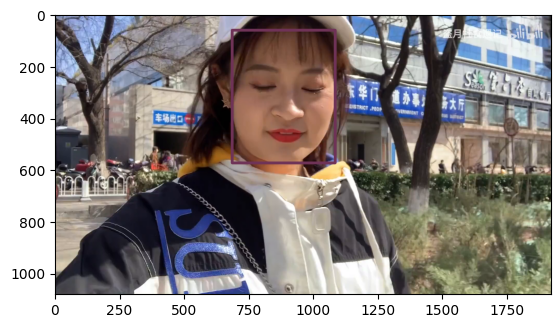

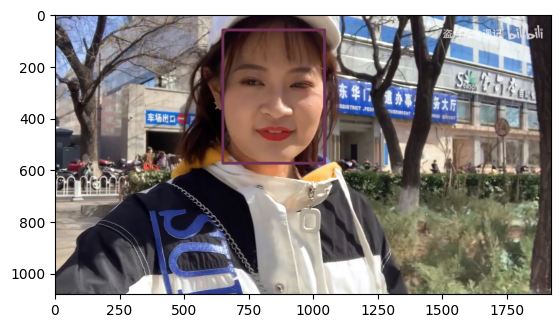

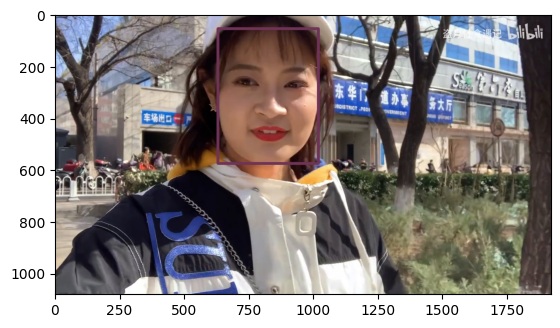

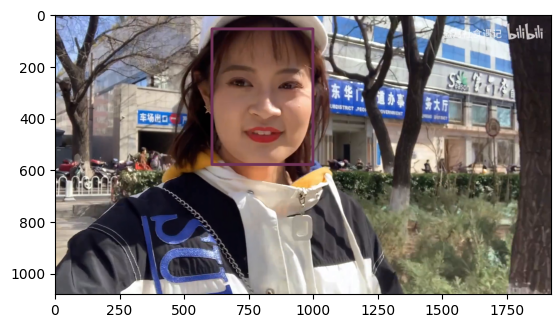

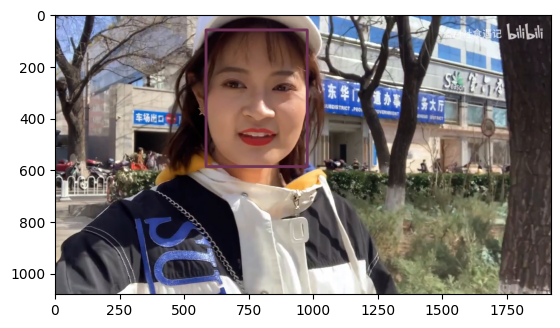

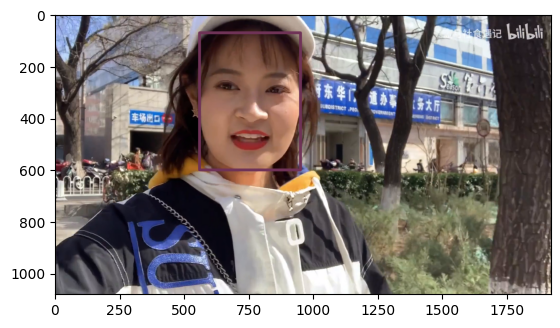

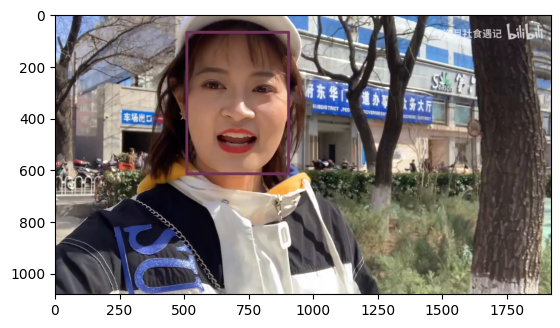

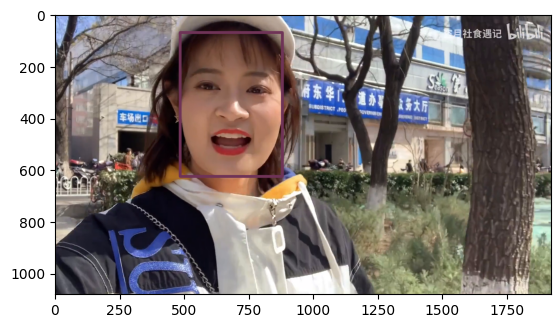

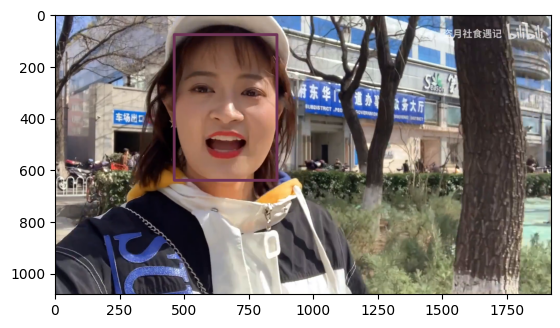

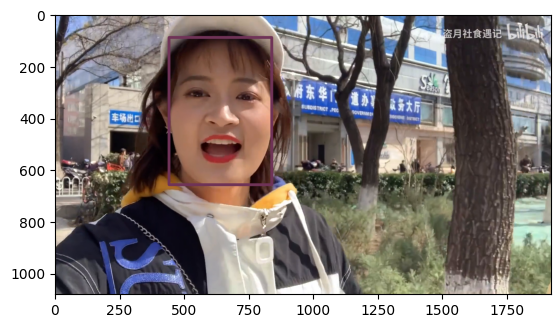

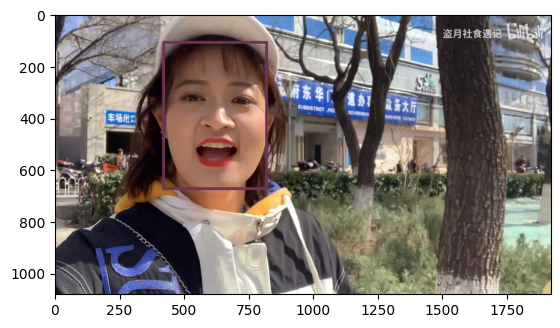

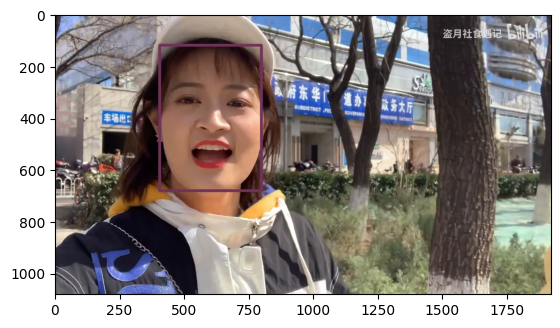

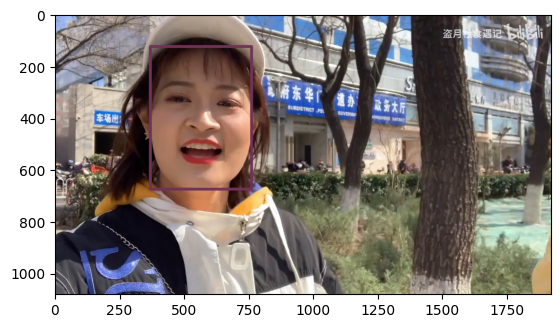

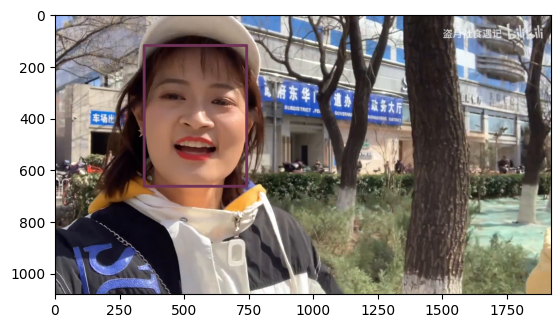

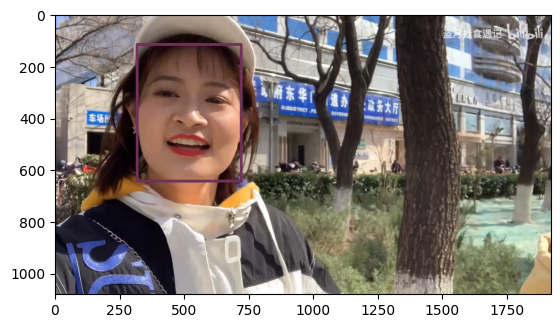

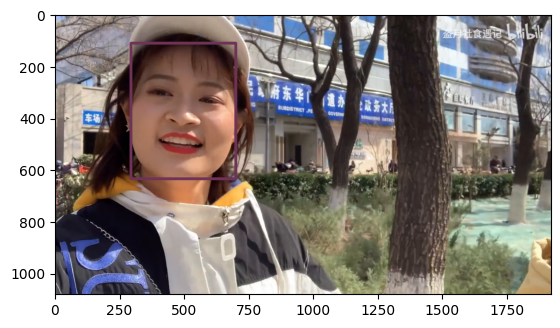

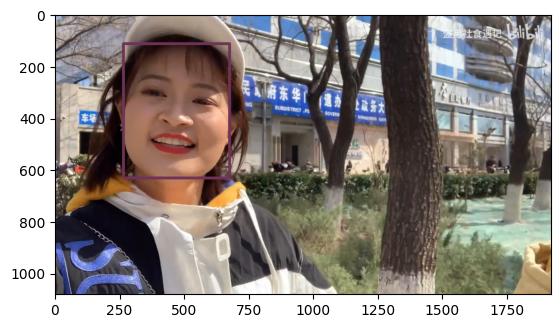

In [10]:
with open('211983720-1-208.mp4', 'rb') as f:
    vr = VideoReader(f, ctx=cpu())
tracker = BoTSORT(recognizer,0.6,0.1,0.4,0.7,30,0.5,0.25,25)
cnt = 0
for clip in scene_manager.get_scene_list():
    start,end = clip
    start,end = start.frame_num, end.frame_num
    clip = [vr[i].asnumpy() for i in range(start,end)]
    clip = np.stack(clip)
    clip_bboxes,clip_kps = face_det(clip,detector)
    for frame,bbox,kps in zip(clip,clip_bboxes,clip_kps):
        online_targets = tracker.update(bbox,kps,frame)
        for t in online_targets:
            tlwh = t.tlwh
            tid = t.track_id
            cv2.rectangle(frame,(int(tlwh[0]),int(tlwh[1])),(int(tlwh[0]+tlwh[2]),int(tlwh[1]+tlwh[3])),get_color(tid),10)
        plt.imshow(frame)
        plt.show()
        if cnt ==30:
            break
        else:
            cnt += 1
    break

In [11]:
len(clip_bboxes)

505

In [21]:
recognizer(crop).shape

(1, 512)

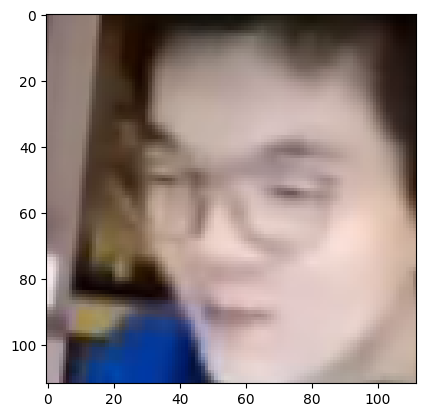

In [48]:
plt.imshow(clip_crops[100][0])

In [28]:
clip_crops[2].shape

(15, 112, 112, 3)

In [25]:
len(clip_crops)

1

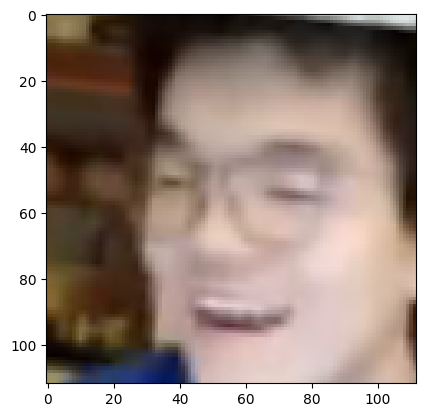

In [11]:
plt.imshow(clip_crops[0])

In [88]:
clip_scores[0].shape

(15,)

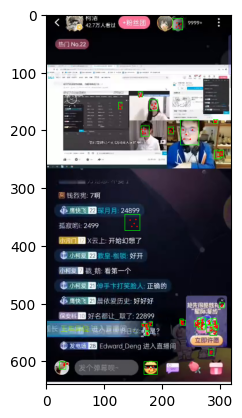

In [66]:
index=500
frame = clip[index].copy()
for box in video_bboxes[index]:
    cv2.rectangle(frame,(int(box[0]),int(box[1])),(int(box[2]),int(box[3])),(0,255,0))
for kps in video_kps[index]:
    for kp in kps:
        cv2.circle(frame,(int(kp[0]),int(kp[1])),1,(255,0,0),-1)
    
plt.imshow(frame)

In [38]:
bboxes[0][0]

array([226.    , 186.9   , 253.8   , 225.2   ,   0.9023], dtype=float16)